## Data quality check / cleaning / preparation 

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.** An example is given below.

In [222]:
import pandas as pd
import numpy as np
from statsmodels.formula.api import ols
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from imblearn.over_sampling import SMOTE
import warnings
import time
import itertools
warnings.filterwarnings("ignore")

test = pd.read_csv("PCOS.csv")

### Data quality check
*By Elton John*

The code below visualizes the distribution of all the variables in the dataset, and their association with the response.

In [223]:
#...Distribution of continuous variables...#

In [224]:
#...Distribution of categorical variables...#

In [225]:
#...Association of the response with the predictors...#

### Data cleaning
*By Yida Hao*

From the data quality check we realized that:

1. The names of predictors directly from the raw dataset included spaces and symbols that created errors when we tried to do EDA. By renaming each variable, we got rid of the errors and also made them easier to call.

2. Some of the predictors were perfectly correlated with other predictors (patient number and patient id), so we removed all of them to avoid issues of perfect multicollinearity.

3. There were only two observations with missing values, so we decided to remove them.

The code below implements the above cleaning.

In [226]:
# Renaming all variables in dataset
test = test.rename(columns={"Sl. No":"num", "Patient File No.": "patient", "PCOS (Y/N)":"PCOS", "Age (yrs)": "age", 
       'Weight (Kg)' : "weight", 'Height(Cm)':"height", "Blood Group": "blood_group",'Pulse rate(bpm)': "pulse_rate",
       'RR (breaths/min)': "RR", 'Hb(g/dl)': "hb", 'Cycle(R/I)': "cycle_ri", 'Cycle length(days)': "cycle",
       'Marraige Status (Yrs)': "marriage_years", 'Pregnant(Y/N)': "pregnant", 'No. of aborptions': "number_abortions",
       '  I   beta-HCG(mIU/mL)': "I", 'II    beta-HCG(mIU/mL)': "II", 'FSH(mIU/mL)': "FAH",
       'LH(mIU/mL)': "LH", 'FSH/LH': "FSH_LH", 'Hip(inch)': "hip", 'Waist(inch)': "waist", 'Waist:Hip Ratio': "hw_ratio",
       'TSH (mIU/L)': "TSH", 'AMH(ng/mL)': "AMH", 'PRL(ng/mL)':"PRL", 'Vit D3 (ng/mL)': "vit",
       'PRG(ng/mL)':"prg", 'RBS(mg/dl)':"rbs", 'Weight gain(Y/N)':"weight_gain", 'hair growth(Y/N)':"hair_growth",
       'Skin darkening (Y/N)': "skin_dark", 'Hair loss(Y/N)': "hair_loss", 'Pimples(Y/N)': "pimples",
       'Fast food (Y/N)': "fast_food", 'Reg.Exercise(Y/N)':"regular_exercise", 'BP _Systolic (mmHg)':"bp_systolic",
       'BP _Diastolic (mmHg)': "bp_distolic", 'Follicle No. (L)':"follicle_L", 'Follicle No. (R)': "follicle_R",
       'Avg. F size (L) (mm)':"ave_size_L", 'Avg. F size (R) (mm)':"ave_size_R", 'Endometrium (mm)':"endometrium", 'Unnamed: 44':"NA"})


In [227]:
# Drop columns that are perfectly correlated with other columns, or non-value columns
test = test.drop('num', axis=1)
test = test.drop('patient', axis=1)
test = test.drop('II', axis=1)
test = test.drop('AMH', axis=1)
test = test.drop('FSH_LH', axis=1)

In [228]:
# Drop obs with missing values
test.isnull().sum()
test = test[~((test['marriage_years'].isnull()) | (test['fast_food'].isnull()))]
test["PCOS"].value_counts()

0    363
1    176
Name: PCOS, dtype: int64

### Data preparation
*By Yida Hao*

The following data preparation steps helped us to prepare our data for implementing various modeling / validation techniques:

1. We derived some new predictors *(from existing predictors)* that intuitively seem to be helpuful/easier measurements of PCOS likelihood. 

2. We created synthetic data points using SMOTE to fix issue of unbalanced data.

3. We changed blood_group predictor from continuous to categorical. Must be done after SMOTE since used in train (which is SMOTEd data)

4. Change all categorical predictors (only blood_group_cat) into dummy variables to use in forward selection.

In [254]:
######---------------Creating new predictors----------------#########

In [ ]:
#Creating BMI
test["BMI"] = test["weight"]/np.square(test["height"])

#Changing unit of height into meters
test["height"] = test["height"]/100

#Creating hw_ratio
test["hw_ratio"] = test["hip"]/test["waist"]

#Drop NA column
test = test.drop(columns = {'NA'})
test.head(2)

In [230]:
######-----------SMOTE------------#########

In [231]:
train = test
train.shape

(539, 39)

In [232]:
train["PCOS"].value_counts()

0    363
1    176
Name: PCOS, dtype: int64

In [233]:
X=train.iloc[:,1:]
y=train.iloc[:,0]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1, random_state = 0)

In [234]:
sm = SMOTE(random_state = 0)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train.ravel())
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))
  
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0)))

Before OverSampling, counts of label '1': 175
Before OverSampling, counts of label '0': 363 

After OverSampling, the shape of train_X: (726, 38)
After OverSampling, the shape of train_y: (726,) 

After OverSampling, counts of label '1': 363
After OverSampling, counts of label '0': 363


In [235]:
y = pd.DataFrame(y_train_res, columns=["PCOS"])
train = pd.concat([X_train_res, y], axis = 1) 
train = train.reindex(columns=["PCOS", 'age', 'weight', 'height', 'BMI', 'blood_group', 'pulse_rate', 'RR',
       'hb', 'cycle_ri', 'cycle', 'marriage_years', 'pregnant',
       'number_abortions', 'I', 'FAH', 'LH', 'hip', 'waist', 'hw_ratio', 'TSH',
       'PRL', 'vit', 'prg', 'rbs', 'weight_gain', 'hair_growth', 'skin_dark',
       'hair_loss', 'pimples', 'fast_food', 'regular_exercise', 'bp_systolic',
       'bp_distolic', 'follicle_L', 'follicle_R', 'ave_size_L', 'ave_size_R',
       'endometrium'])

In [236]:
######-----Creating blood_grouo_cat predictors-------#########

In [237]:
# Creating a dictionary of replacement values for each blood_group category
blood_group_map = {11: "A_pos", 12: "A_neg", 13: "B_pos", 14: "B_neg", 15: "O_pos", 16: "O_neg", 17: "AB_pos", 18: "AB_neg"}

# Mapping to the test dataset
test.loc[:, "blood_group_cat"] = test.loc[:, "blood_group"].map(blood_group_map)

In [238]:
# Removing original continuous blood_group predictor
test = test.drop('blood_group', axis=1)
test.head(2)

,PCOS,age,weight,height,BMI,pulse_rate,RR,hb,cycle_ri,cycle,...,fast_food,regular_exercise,bp_systolic,bp_distolic,follicle_L,follicle_R,ave_size_L,ave_size_R,endometrium,blood_group_cat
0,0,28,44.6,1.520,0.001930,78,22,10.48,2,5,...,1.0,0,110,80,3,3,18.0,18.0,8.5,O_pos
1,0,36,65.0,1.615,0.002492,74,20,11.70,2,5,...,0.0,0,120,70,3,5,15.0,14.0,3.7,O_pos


In [239]:
# Repeating for train data (that is SMOTEd)
blood_group_map = {11: "A_pos", 12: "A_neg", 13: "B_pos", 14: "B_neg", 15: "O_pos", 16: "O_neg", 17: "AB_pos", 18: "AB_neg"}
train.loc[:, "blood_group_cat"] = train.loc[:, "blood_group"].map(blood_group_map)

train = train.drop('blood_group', axis=1)
train.tail(2)

,PCOS,age,weight,height,BMI,pulse_rate,RR,hb,cycle_ri,cycle,...,fast_food,regular_exercise,bp_systolic,bp_distolic,follicle_L,follicle_R,ave_size_L,ave_size_R,endometrium,blood_group_cat
724,1,29,62.586575,1.522756,0.002700,72,18,11.458657,2,5,...,1.0,0,118,80,4,7,11.240276,15.275617,8.731451,B_neg
725,1,32,63.000000,1.638646,0.002346,72,18,10.975628,4,8,...,1.0,0,110,80,5,6,18.027081,20.891678,8.978336,O_neg


In [255]:
######-----Changing categorical predictors to dummy for forward selection-------#########

In [240]:
# Creating dummy variables for each category in blood_group_cat to use in forward selection
train = pd.get_dummies(train, columns = ['blood_group_cat'])
test = pd.get_dummies(test, columns = ['blood_group_cat'])

## Exploratory data analysis

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**

***By Yida***

In [241]:
# Baseline Model for comparison

In [242]:
import statsmodels.formula.api as sm

In [243]:
predictors = list(train.columns)[1:train.shape[1]-1]

In [244]:
baseline = sm.logit('PCOS ~' + '+'.join(predictors), data = train).fit()
baseline.summary()

         Current function value: 1.871130
         Iterations: 35


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   PCOS   No. Observations:                  726
Model:                          Logit   Df Residuals:                      681
Method:                           MLE   Df Model:                           44
Date:                Sun, 12 Mar 2023   Pseudo R-squ.:                  -1.699
Time:                        15:52:41   Log-Likelihood:                -1358.4
converged:                      False   LL-Null:                       -503.22
Covariance Type:            nonrobust   LLR p-value:                     1.000
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               3655.5753   1100.468      3.322      0.001    1498.698    5812.452
age                       -2.0899      0.673     -3.104      0.002      -3.410      -0.770
weight                    29.3856      8.808      3.336      0.001      12.121      46.650
height                 -2257.3126    675.620     -3.341      0.001   -3581.503    -933.122
BMI                    -7.269e+05   2.18e+05     -3.338      0.001   -1.15e+06      -3e+05
pulse_rate                 0.2000      0.258      0.775      0.438      -0.306       0.706
RR                        -2.0386      0.761     -2.678      0.007      -3.530      -0.547
hb                         1.4413      0.687      2.097      0.036       0.094       2.788
cycle_ri                   6.0278      1.768      3.410      0.001       2.564       9.492
cycle                     -1.5909      0.524     -3.038      0.002      -2.617      -0.565
marriage_years             0.8448      0.349      2.423      0.015       0.161       1.528
pregnant                  -5.0439      2.014     -2.504      0.012      -8.992      -1.096
number_abortions         -14.3513      4.080     -3.517      0.000     -22.348      -6.354
I                         -0.0008      0.000     -3.119      0.002      -0.001      -0.000
FAH                       -0.3414      0.121     -2.827      0.005      -0.578      -0.105
LH                         0.2300      0.180      1.280      0.200      -0.122       0.582
hip                        4.5769      2.253      2.032      0.042       0.161       8.992
waist                     -4.4367      2.337     -1.899      0.058      -9.017       0.143
hw_ratio                -163.5246     75.025     -2.180      0.029    -310.570     -16.479
TSH                        0.9724      0.287      3.385      0.001       0.409       1.535
PRL                       -0.0998      0.059     -1.694      0.090      -0.215       0.016
vit                       -0.0014      0.002     -0.880      0.379      -0.004       0.002
prg                       -8.6501      2.751     -3.144      0.002     -14.042      -3.258
rbs                        0.2399      0.073      3.285      0.001       0.097       0.383
weight_gain               17.1333      5.121      3.346      0.001       7.097      27.170
hair_growth               19.1564      5.728      3.344      0.001       7.929      30.384
skin_dark                  7.0367      2.435      2.890      0.004       2.265      11.808
hair_loss                 -5.4730      1.854     -2.952      0.003      -9.107      -1.839
pimples                    9.5015      3.061      3.104      0.002       3.501      15.502
fast_food                  6.6555      2.238      2.974      0.003       2.269      11.042
regular_exercise          -2.3788      1.478     -1.610      0.107      -5.275       0.518
bp_systolic               -0.2956      0.148     -2.003      0.045      -0.585      -0.006
bp_distolic                0.5844      0.224      2.609 

In [245]:
def confusion_matrix_train(model, cutoff=0.5):
# Confusion matrix
    cm_df = pd.DataFrame(model.pred_table(cutoff))
    #Formatting the confusion matrix
    cm_df.columns = ['Predicted 0', 'Predicted 1'] 
    cm_df = cm_df.rename(index={0: 'Actual 0',1: 'Actual 1'})
    cm = np.array(cm_df)
    sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
    # Calculate the accuracy
    accuracy = (cm[0,0]+cm[1,1])/cm.sum()
    false_neg = cm[1,0]/(cm[1,0]+cm[1,1])
    false_pos = cm[0,1]/(cm[0,1]+cm[0,0])
    print("Classification accuracy = {:.4%}".format(accuracy))
    print("False Negative = {:.4%}".format(false_neg))
    print("False Positive = {:.4%}".format(false_pos))
    
def confusion_matrix_test(data,actual_values,model,cutoff=0.3):
    #Predict the values using the Logit model
    pred_values = model.predict(data)
    # Specify the bins
    bins=np.array([0,cutoff,1])
    #Confusion matrix
    cm = np.histogram2d(actual_values, pred_values, bins=bins)[0]
    cm_df = pd.DataFrame(cm)
    cm_df.columns = ['Predicted 0','Predicted 1']
    cm_df = cm_df.rename(index={0: 'Actual 0',1:'Actual 1'})
    sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
    # Calculate the accuracy
    accuracy = (cm[0,0]+cm[1,1])/cm.sum()
    # Return the confusion matrix and the accuracy
    false_neg = cm[1,0]/(cm[1,0]+cm[1,1])
    false_pos = cm[0,1]/(cm[0,1]+cm[0,0])
    print("Classification accuracy = {:.4%}".format(accuracy))
    print("False Negative = {:.4%}".format(false_neg))
    print("False Positive = {:.4%}".format(false_pos))

Classification accuracy = 88.2920%
False Negative = 11.5702%
False Positive = 11.8457%


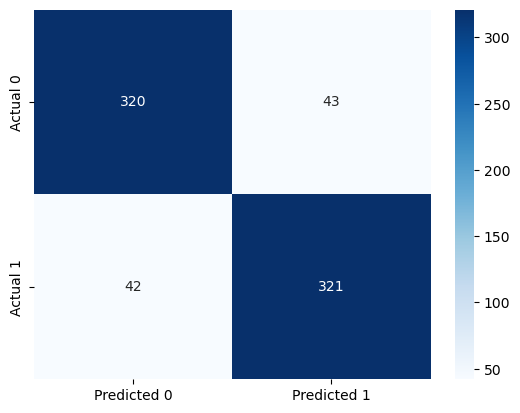

In [246]:
confusion_matrix_train(baseline, 0.4)

## Developing the model

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**

***By Yida***

#### Forward Selection

In [247]:
X = train[['age', 'weight', 'height', 'BMI', 'pulse_rate',
       'RR', 'hb', 'cycle_ri', 'cycle', 'marriage_years', 'pregnant',
       'number_abortions', 'I', 'FAH', 'LH', 'hip', 'waist', 'hw_ratio', 'TSH',
       'PRL', 'vit', 'prg', 'rbs', 'weight_gain', 'hair_growth', 'skin_dark',
       'hair_loss', 'pimples', 'fast_food', 'regular_exercise', 'bp_systolic',
       'bp_distolic', 'follicle_L', 'follicle_R', 'ave_size_L', 'ave_size_R',
       'endometrium', 'blood_group_cat_AB_neg', 'blood_group_cat_AB_pos',
       'blood_group_cat_A_neg', 'blood_group_cat_A_pos',
       'blood_group_cat_B_neg', 'blood_group_cat_B_pos',
       'blood_group_cat_O_neg']]


In [248]:
def processSubset(predictor_subset):
    # Fit model on feature_set and calculate R-squared
    model = sm.logit('PCOS~' + '+'.join(predictor_subset), data = train).fit()
    llr = model.llr
    return {"model":model, "llr":llr}
def getBest_model(k):
    tic = time.time()
    results = []
    for combo in itertools.combinations(X.columns, k):
        results.append(processSubset((list(combo))))

    # Wrap everything up in a dataframe
    models = pd.DataFrame(results)

    # Choose the model with the highest RSS
    best_model = models.loc[abs(models['llr']).argmax()]
    
    toc = time.time()
    print("Processed", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.")
    return best_model
def forward(predictors):

    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X.columns if p not in predictors]
    
    tic = time.time()
    
    results = []
    
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p]))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['llr'].argmax()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model
def forward_selection():
    models_best = pd.DataFrame(columns=["llr", "model"])
    
    tic = time.time()
    predictors = []

    for i in range(1,len(X.columns)+1):    
        models_best.loc[i] = forward(predictors)
        predictors = list(models_best.loc[i]["model"].params.index[1:])

    toc = time.time()
    print("Total elapsed time:", (toc-tic), "seconds.")
    return models_best

In [249]:
models_best = forward_selection()

Optimization terminated successfully.
         Current function value: 0.660158
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.668032
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691378
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.668827
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.691171
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692927
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690014
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.637006
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.663741
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.681633
  

Optimization terminated successfully.
         Current function value: 0.354799
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.360330
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.358164
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.360217
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.339266
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.354452
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.354242
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.352867
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.358190
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.357761
  

Optimization terminated successfully.
         Current function value: 0.309989
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.311746
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.307546
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.301035
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.306438
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.308343
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.305720
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.309791
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.304998
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.311402
 

Optimization terminated successfully.
         Current function value: 0.278829
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.276553
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.278212
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.280846
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.275312
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.281844
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.281310
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.280684
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.281777
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.281185
 

Optimization terminated successfully.
         Current function value: 0.262438
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.262522
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.261892
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.262441
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.262542
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.259415
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.259823
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.262464
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.259599
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.262524
 

Optimization terminated successfully.
         Current function value: 0.250617
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.249616
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.250881
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.250988
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.249346
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.250824
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.250807
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.250963
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.251022
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.2

Optimization terminated successfully.
         Current function value: 0.237665
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.238932
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.239757
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.239674
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.239730
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.238532
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.239744
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.239763
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.237734
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.

Optimization terminated successfully.
         Current function value: 0.235301
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.235332
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.235008
         Iterations 10
Processed  29 models on 16 predictors in 1.838303804397583 seconds.
Optimization terminated successfully.
         Current function value: 0.233345
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.233482
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.233373
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.232716
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.231962
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.233472
         Iterations 10
Optim

Optimization terminated successfully.
         Current function value: 0.229896
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.229653
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.230151
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.230130
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.229905
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.229869
         Iterations 10
Processed  26 models on 19 predictors in 1.8966701030731201 seconds.
Optimization terminated successfully.
         Current function value: 0.226795
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.227249
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.226631
         Iterations 13
Opti

Optimization terminated successfully.
         Current function value: 0.223728
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.222881
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.223652
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.223676
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.223268
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.223061
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.223551
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.223434
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.223729
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.

Optimization terminated successfully.
         Current function value: 0.220908
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.220915
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.220834
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.220847
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.220375
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.220600
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.220915
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.220418
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.220916
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.

Optimization terminated successfully.
         Current function value: 0.219285
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.219152
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.219209
         Iterations 14
Processed  14 models on 31 predictors in 1.4651000499725342 seconds.
Optimization terminated successfully.
         Current function value: 0.219089
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.219080
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.219072
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.218948
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.218981
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.219049
         Iterations 15
Opti

Optimization terminated successfully.
         Current function value: 0.216499
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.216489
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.216494
         Iterations 15
Processed  6 models on 39 predictors in 0.6767818927764893 seconds.
         Current function value: 1.912319
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.216487
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.216487
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.216478
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.216484
         Iterations 15
Processed  5 models on 40 predictors in 0.5550410747528076 seconds.
         Current function value: 1.918767
         Iterations: 35
Optimizatio

In [250]:
def best_sub_plots():
    plt.figure(figsize=(20,10))
    plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

    # Set up a 2x2 grid so we can look at 4 plots at once
    plt.subplot(1, 2, 1)

    # We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
    aic = models_best.apply(lambda row: row[1].aic, axis=1)

    plt.subplot(2, 2, 3)
    plt.plot(aic)
    plt.plot(1+aic.argmin(), aic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('AIC')

    bic = models_best.apply(lambda row: row[1].bic, axis=1)

    plt.subplot(2, 2, 4)
    plt.plot(bic)
    plt.plot(1+bic.argmin(), bic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('BIC')

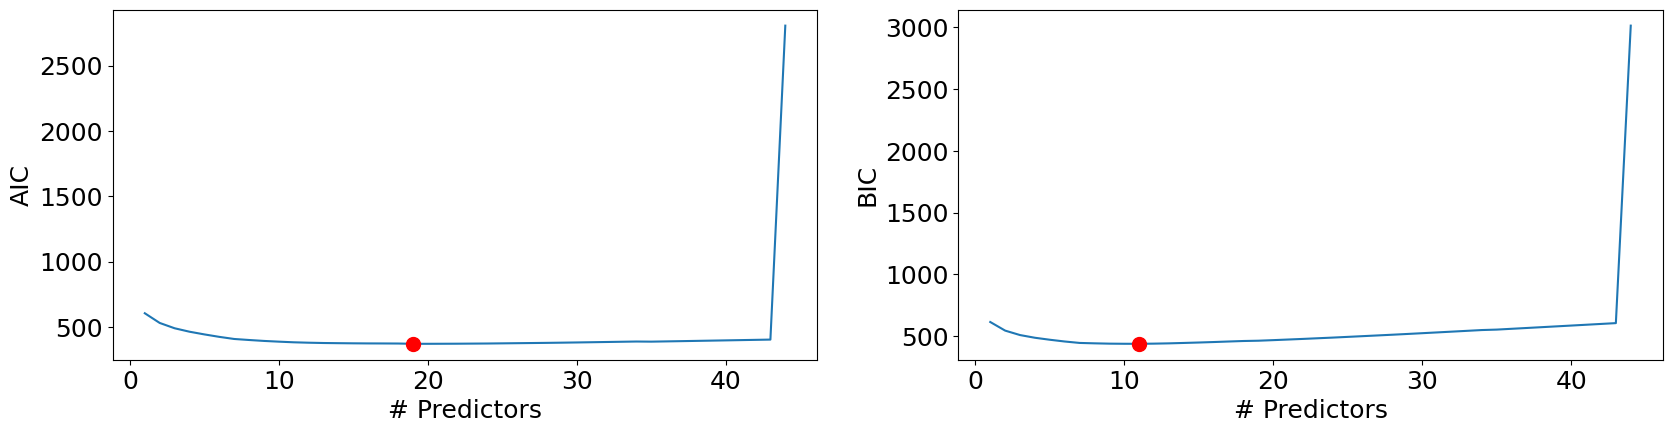

In [251]:
best_sub_plots()

In [252]:
best_fwd_reg_model = models_best['model'][11]
best_fwd_reg_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   PCOS   No. Observations:                  726
Model:                          Logit   Df Residuals:                      714
Method:                           MLE   Df Model:                           11
Date:                Sun, 12 Mar 2023   Pseudo R-squ.:                  0.6447
Time:                        15:53:38   Log-Likelihood:                -178.79
converged:                       True   LL-Null:                       -503.22
Covariance Type:            nonrobust   LLR p-value:                4.867e-132
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -5.6811      1.028     -5.526      0.000      -7.696      -3.666
follicle_R                0.4167      0.056      7.416      0.000       0.307       0.527
fast_food                 1.3721      0.304      4.513      0.000       0.776       1.968
hair_growth               1.4416      0.329      4.377      0.000       0.796       2.087
cycle_ri                  0.6550      0.168      3.898      0.000       0.326       0.984
blood_group_cat_B_neg     2.4122      0.591      4.084      0.000       1.255       3.570
weight_gain               1.5492      0.311      4.976      0.000       0.939       2.159
age                      -0.0907      0.027     -3.314      0.001      -0.144      -0.037
skin_dark                 1.0046      0.308      3.265      0.001       0.401       1.608
LH                        0.1077      0.057      1.876      0.061      -0.005       0.220
follicle_L                0.1631      0.055      2.964      0.003       0.055       0.271
number_abortions         -0.6510      0.262     -2.489      0.013      -1.164      -0.138
=========================================================================================
"""

Classification accuracy = 90.1670%
False Negative = 4.5455%
False Positive = 12.3967%


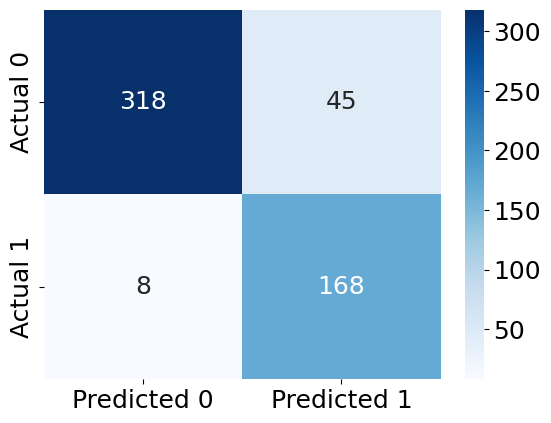

In [253]:
confusion_matrix_test(test, test.PCOS, best_fwd_reg_model, cutoff = 0.40)

#### VIF

### Code fitting the final model

Put the code(s) that fit the final model(s) in separate cell(s), i.e., the code with the `.ols()` or `.logit()` functions.

In [185]:
final = sm.logit('PCOS ~ follicle_R + fast_food + hair_growth + cycle_ri + blood_group_cat_B_neg + weight_gain + age + follicle_L + LH + skin_dark + number_abortions', data = train).fit()

Optimization terminated successfully.
         Current function value: 0.246268
         Iterations 10


Classification accuracy = 90.4959%
False Negative = 6.6116%
False Positive = 12.3967%


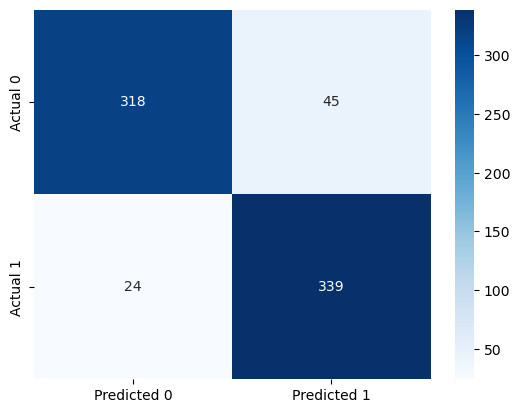

In [186]:
confusion_matrix_train(final, 0.4)

## Conclusions and Recommendations to stakeholder(s)

You may or may not have code to put in this section. Delete this section if it is irrelevant.